# GOES Infrared Satellite Images
### Channels avaliable in this notebook are:
* 13 - Clean Longwave IR:  10.3 $\mu m$

## Justin Richling
## 09/20/18

http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi

## Imports

In [90]:
# Random Library Imports
import subprocess,os,glob

# Importing Datetime Libraries
from datetime import datetime, date

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Numerical and Scientific Libraries
import numpy as np

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# Matplotlib Plotting Libraries
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patheffects
from matplotlib.colors import ListedColormap

import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeat

In [60]:
from satpy import Scene, DatasetID
from satpy.writers import get_enhanced_image

In [61]:
filename = glob.glob("*L1b*")
scn = Scene(reader='abi_l1b', filenames=filename)
product="C01"
scn.load([product])
 
new_scn = scn.resample(resampler='native') #scn.min_area(),
var = get_enhanced_image(new_scn[product]).data

    # Get true color data to use later and reorder the dimensions so matplotlib can use the image
    # Sadly, this operation is not lazy (bad performance) in xarray at the time of writing
var = var.transpose('y', 'x', 'bands')
abi_crs = var.attrs['area'].to_cartopy_crs()

In [91]:
import pandas as pd
ir = pd.read_csv("/Users/chowdahead/Documents/ir_cmap.csv")
ir_colors = []
for i in range(0,2048):
    ir_colors.append((float(ir["r"][i]),
                               float(ir["g"][i]),
                               float(ir["b"][i]),
                               float(ir["a"][i])
                             ))
cmap_name="ir"
ir_cmap = LinearSegmentedColormap.from_list(
            cmap_name, ir_colors)

ir_cmap_r = ListedColormap(ir_colors[::-1])
#ir_cmap_r = cm.revcmap(ir_cmap)

In [2]:
# Set the font 
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

In [3]:
# Unidata/MetPy Dictionary of GOES channels

channel_list = {u'1 - Blue Band 0.47 \u03BCm': 1,
                u'2 - Red Band 0.64 \u03BCm': 2,
                u'3 - Veggie Band 0.86 \u03BCm': 3,
                u'4 - Cirrus Band 1.37 \u03BCm': 4,
                u'5 - Snow/Ice Band 1.6 \u03BCm': 5,
                u'6 - Cloud Particle Size Band 2.2 \u03BCm': 6,
                u'7 - Shortwave Window Band 3.9 \u03BCm': 7,
                u'8 - Upper-Level Tropo. WV Band 6.2 \u03BCm': 8,
                u'9 - Mid-Level Tropo. WV Band 6.9 \u03BCm': 9,
                u'10 - Low-Level WV Band 7.3 \u03BCm': 10,
                u'11 - Cloud-Top Phase Band 8.4 \u03BCm': 11,
                u'12 - Ozone Band 9.6 \u03BCm': 12,
                u'13 - Clean IR Longwave Band 10.3 \u03BCm': 13,
                u'14 - IR Longwave Band 11.2 \u03BCm': 14,
                u'15 - Dirty Longwave Band 12.3 \u03BCm': 15,
                u'16 - CO2 Longwave IR 13.3 \u03BCm': 16}

# Archived Data

In [5]:
# Set the date you want to convert
dt = datetime(2019, 8, 25)
#dt = now

# Start of year for reference
d0 = datetime(2019, 1, 1)

# Find the difference and add one to get the day number of the calander year
delta = dt - d0
Julian_Day = delta.days+1
if Julian_Day < 100:
    Julian_Day = "0"+str(Julian_Day)
    if int(Julian_Day) < 10:
        Julian_Day = "0"+str(Julian_Day)

Year = str('{0:%Y}'.format(dt))
Month = str('{0:%m}'.format(dt))
Day = str('{0:%d}'.format(dt))
Hour = str('{0:%H}'.format(dt))
Minute = str('{0:%m}'.format(dt))

#'{0:%Y}'.format(dt)+"-"+'{0:%m}'.format(dt)+"-"+'{0:%d}'.format(dt)+"-"+'{0:%H}'.format(dt)
print(f"date: {Year}-{Month}-{Day} {Hour}{Minute}Z")

# Julian day (Day)
print("Julian number: ",Julian_Day)

date: 2019-08-25 0008Z
Julian number:  237


In [35]:
%%time

# rclone AWS data access via remote server
# Day must be Julian day number
! rclone --include "OR_*-M6C13*.nc" copy Public-AWS:noaa-goes16/ABI-L2-CMIPC/2020/130/00/ ./


CPU times: user 306 ms, sys: 102 ms, total: 408 ms
Wall time: 14.9 s


In [15]:
# Check to make sure the data went to the right path
GOES_file_path = "/Users/chowdahead/Downloads/WX_Data/GOES_Data"
#GOES_file_path = "GOES_Data"
GOES_file_path

'/Users/chowdahead/Downloads/WX_Data/GOES_Data'

# --------------------------------------------------------------------------------------------

# Populate the Lists for Different Channels

In [10]:
os.chdir("/Users/chowdahead/Downloads/WX_Data/GOES_Data")

In [41]:
GOES_files = []

for name in glob.glob(GOES_file_path+'/*CMIPC*M6C13*.nc'):
    GOES_files.append(name)
    #for name in glob.glob(GOES_sample_path+'OR*L2*RadC*C09*G16*s'+Year+str(Julian_Day)+'*.nc'):
    #    GOES16_samples_9.append(name)

GOES_files = sorted(GOES_files)
print(len(GOES_files))
print(GOES_files[0])

12
/Users/chowdahead/Downloads/WX_Data/GOES_Data/OR_ABI-L2-CMIPC-M6C13_G16_s20201300001113_e20201300003497_c20201300004017.nc


# Single images here; loops are further down in the notebook

## IR - Channel 13
With the help of searching through some Unidata public emails, I was able to find the color table for the NESDIS IR colorbar. 
* https://www.unidata.ucar.edu/mailing_lists/archives/ldm-users/2018/msg00055.html

<h1>We can also define a map projection function that can take details of the different channels</h1>

* path - data file location
* savepath - image save location
* my_cmap - (optional) desired color table
* vmin - (optional) min value for plotting
* vmax - (optional) max value for plotting

In [ ]:
def make_text_time_right(ax,end,title_time,dataset,
                         color="w",
                       fontsize=12):  
    
    text_time = ax.text(.995, 0.01, 
            f"{dataset} (dbz)"+"\n"+title_time,
            horizontalalignment='right', transform=ax.transAxes,
            color=color, fontsize=fontsize, weight='bold',zorder=15)
    outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    text_time.set_path_effects(outline_effect)
    return text_time,ax

def make_text_time_left(ax,station, prod_name,product,
                        color="w",
                       fontsize=12):  
    
    text_time2 = ax.text(0.005, 0.01, 
                "Station: "+station+"\n"+prod_name+" ("+product+")",
                horizontalalignment='left', transform=ax.transAxes,
                color=color, fontsize=fontsize, weight='bold',zorder=15)
    outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    text_time2.set_path_effects(outline_effect)
    return text_time2,ax




text_time = ax.text(.995, 0.01, 
        vis_name[27:31]+" "+'{0:%B %d}'.format(Day)+" "+vis_name[34:36]+""+vis_name[36:38]+"Z",
        horizontalalignment='right', transform=ax.transAxes,
        color='white', fontsize=20, weight='bold')

    text_time2 = ax.text(0.005, 0.01, 
        title,
        horizontalalignment='left', transform=ax.transAxes,
        color='white', fontsize=20, weight='bold')

    outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    text_time.set_path_effects(outline_effect)
    text_time2.set_path_effects(outline_effect)

In [45]:
def get_sat_data(GOES_file):
    nc = Dataset(GOES_file)
    data = nc.variables['CMI'][:]
        
    proj_var = nc.variables['goes_imager_projection']
    sat_h = nc.variables['goes_imager_projection'].perspective_point_height

    Time = str(datetime.strptime(nc.time_coverage_start[:-6], '%Y-%m-%dT%H:%M'))
    Time = Time[0:10]+Time[11:16]
    timestamp = datetime.strptime(Time, '%Y-%m-%d%H:%M')
    file_time = timestamp.strftime('%Y_%m_%d_%H%M')
    title_time = timestamp.strftime('%d %B %Y %H:%MZ')

    
    X = nc.variables['x'][:] * sat_h
    Y = nc.variables['y'][:] * sat_h
        #ch2nc.close()
        #ch2nc = None
    return X,Y,title_time,file_time,data,proj_var,sat_h

In [46]:
X,Y,title_time,file_time,data,proj_var,sat_h = get_sat_data(GOES_files[0])

In [47]:
title_time

'09 May 2020 00:01Z'

In [ ]:
    
    vmin = 164
    vmax = 330

In [48]:
def get_product_cbar_args(sat_name,cbar,outline_effect):
    if sat_name == "ch13":
        ticks = np.arange(170,331,40)
       
    if sat_name == "ch2":
        ticks = [-60,-45,-20,0,20,45,60]    
    
    Y = 240    
    for count,ele in enumerate(ticks,0): 
        cbar.ax.text(ele, Y, ticks[count], ha='center', va='center',
                     path_effects=outline_effect,color="w",fontsize=6)


In [ ]:
GOES_samples[0]
plot_goes(sat_file,savepath,extent,my_cmap=None,vmin=None,vmax=None)

In [80]:
def plot_goes(GOES_file,savepath,extent,my_cmap=None,vmin=None,vmax=None,show=False):
    
    X,Y,title_time,file_time,data,proj_var,sat_h = get_sat_data(GOES_file)

# Create new figure
    fig = plt.figure(figsize=(17,11))

# Add state boundaries to plot
    states_boundaries = cfeature.NaturalEarthFeature(category='cultural',
        name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

    country_borders = cfeature.NaturalEarthFeature(category='cultural',
        name='admin_0_countries',scale='50m', facecolor='none')
    
# Set Projection of Plot
    #globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
    #crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)
    #plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)
    plotcrs = ccrs.LambertConformal(central_longitude=-99.969 ,central_latitude=37.761)

# Add the map and set the extent
    ax = plt.subplot(111, projection=abi_crs) 
        
    #reader = shpreader.Reader('/Users/chowdahead/Documents/shapefiles/countyl010g_shp_nt00964/countyl010g.shp')
    #counties = list(reader.geometries())
    #COUNTIES = cfeat.ShapelyFeature(counties,ccrs.PlateCarree())
    #ax.add_feature(COUNTIES, facecolor='none',edgecolor='r')
    
# Find and convert Julian day to date    
    
# Set the plot title    
    

# Add state boundaries to plot
    ax.add_feature(states_boundaries, edgecolor='blue', linewidth=1)

# Add country borders to plot
    ax.add_feature(country_borders, edgecolor='black', linewidth=1)

# Set the plotting extent    
    #ax.set_extent(extent, ccrs.PlateCarree()) # Eastern Pacific

# Plot the image
    #img = ax.imshow(data[:],origin='upper',vmin=vmin,vmax=vmax,extent=(X.min(), X.max(), Y.min(), Y.max()),
    #    interpolation='nearest',transform=crs,cmap=my_cmap) 

    ax.set_extent(extent)

    #ax.gridlines(color="w", linestyle="dotted",alpha=0.5)

    im = plt.imshow(data,origin='upper',extent=(X.min(), X.max(), Y.min(), Y.max()),
                interpolation='nearest',vmin=vmin,vmax=vmax,cmap=my_cmap, transform=abi_crs) #,vmin=vmin,vmax=vmax
    
    #ticks = np.arange(170,331,40)
    outline_effect = [patheffects.withStroke(linewidth=3, foreground='black')]
    #outline_effect2 = [patheffects.withStroke(linewidth=2, foreground='w')]


    cbar = plt.colorbar(im,orientation="horizontal") #,ticks=ticks
    posn = ax.get_position()
    cbar.ax.set_position([posn.x0+0.001, posn.y0-0.001,
                            (posn.x1-posn.x0)/2, posn.height])
    
    get_product_cbar_args("ch13",cbar,outline_effect)
    
    
    cbar.set_ticks([])
    cbar.ax.set_xticklabels([])
    
# Display the figure
    if show == True:
        plt.show()
    
# Set the name for saved figure, and save it 
    outfile = f"{file_time}_goes.png"
        
    fig.savefig(f"{save_path}{outfile}",bbox_inches="tight",dpi=100)

## We can now imput data from the different channels and have our generic map maker function run on each to produce our satellite images!

### Map Arguments: Map(path, channel, title, savepath, my_cmap, vmin=None, vmax=None)

In [65]:
save_path = "/Users/chowdahead/Desktop/"
save_path

'/Users/chowdahead/Desktop/'

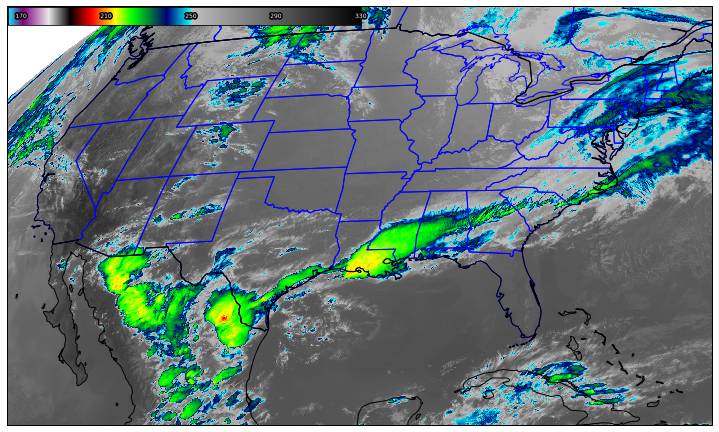

In [92]:
# Map(path,channel,title,savepath,extent,my_cmap=None,vmin=None,vmax=None)

i = 2
#Map(GOES16_samples_13[i],channel,title,save_path,extent,IR_cmap,vmin=162.,vmax=330.)
plot_goes(GOES_files[i],save_path,extent,my_cmap=ir_cmap_r,vmax=330,vmin=164,show=True)

<h2>----------------------------------------------//---------------------------------------------------------</h2>
<h2>----------------------------------------------//---------------------------------------------------------</h2>